In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from random import choice
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [2]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values  # features
    y = data.iloc[:, -1].values   # label
    return X, y

def compute_centroids(X_train, y_train):
    y_train = np.array(y_train)
    classes = np.unique(y_train)
    centroids = {}
    for cls in classes:
        centroids[cls] = X_train[y_train == cls].mean(axis=0)
    return centroids

def predict_with_centroids(X, centroids):
    predictions = []
    for x in X:
        distances = {cls: np.linalg.norm(x - centroid) for cls, centroid in centroids.items()}
        min_distance = min(distances.values())
        closest_classes = [cls for cls, dist in distances.items() if dist == min_distance]
        predicted_class = choice(closest_classes) 
        predictions.append(predicted_class)
    return np.array(predictions)

In [3]:
# Load data
X_train, y_train = load_data("Train_Set.csv")
X_test, y_test = load_data("Test_Set.csv")
X_val, y_val = load_data("Validation_Set.csv")

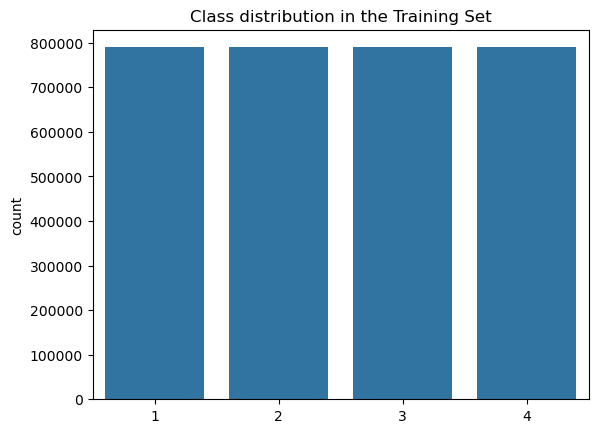

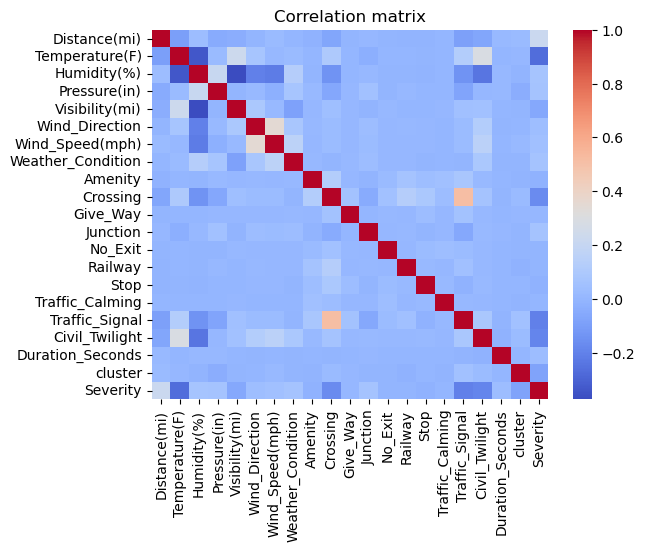

In [4]:
# Class distribution
sns.countplot(x=y_train)
plt.title("Class distribution in the Training Set")
plt.show()

# Correlation matrix
df_train = pd.read_csv("Train_Set.csv")
sns.heatmap(df_train.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

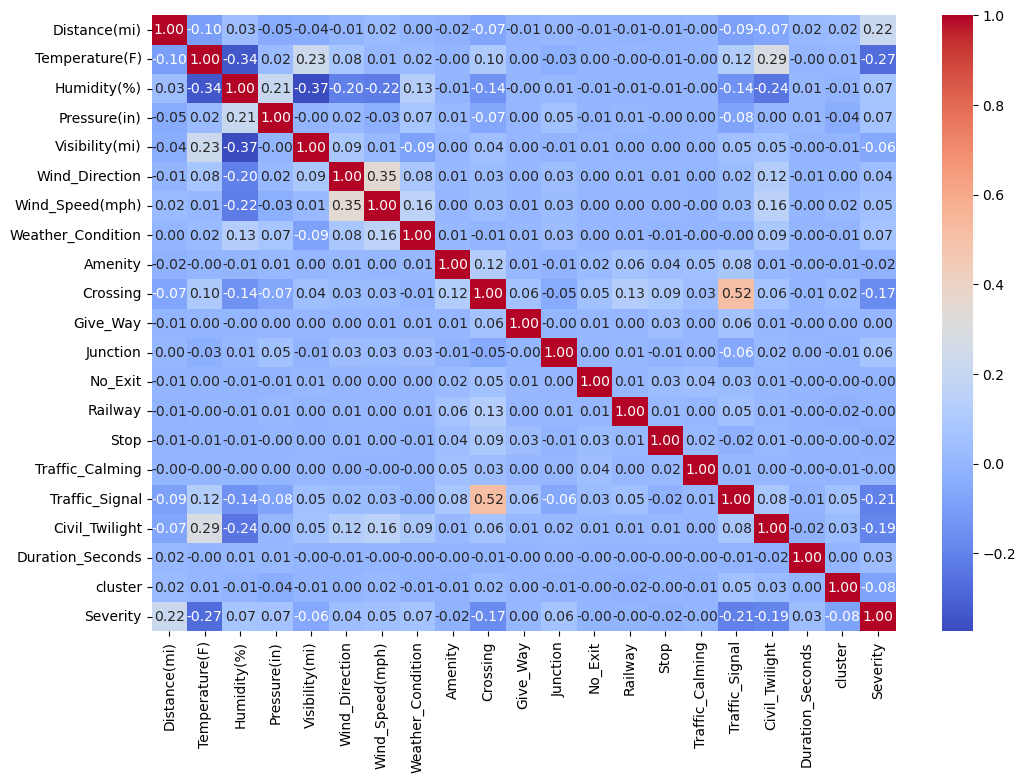

In [5]:
data = pd.read_csv("Train_Set.csv")

numerical_data = data.select_dtypes(include=["float64", "int64"])
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.show()

In [6]:
centroids = compute_centroids(X_train, y_train)

In [7]:
# Test set prediction and validation
y_test_pred = predict_with_centroids(X_test, centroids)
y_val_pred = predict_with_centroids(X_val, centroids)

In [8]:
test_accuracy = accuracy_score(y_test, y_test_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

#print("\nClassification Report (Validation):")
#print(classification_report(y_val, y_val_pred))


Classification Report (Test):
              precision    recall  f1-score   support

           1       0.02      0.61      0.04      9267
           2       0.87      0.16      0.27    830594
           3       0.24      0.48      0.32    169214
           4       0.04      0.38      0.07     25100

    accuracy                           0.22   1034175
   macro avg       0.29      0.41      0.17   1034175
weighted avg       0.73      0.22      0.27   1034175



In [9]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted class")
    plt.ylabel("Real Class")
    plt.title(title)
    plt.show()

def plot_pca(X, y, centroids):
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette="viridis", style=y, s=50, legend="full")
    
    for centroid in centroids.values():
        centroid_reduced = pca.transform([centroid])
        plt.scatter(centroid_reduced[0, 0], centroid_reduced[0, 1], c="red", s=200, label="Centroid", marker="X")
    
    plt.title("PCA (Test Set)")
    plt.legend()
    plt.show()

max_pt = 10000   
def plot_tsne(X, y):
    if len(X) > max_pt:
        X, _, y, _ = train_test_split(X, y, train_size=max_pt, stratify=y, random_state=42)
    
    tsne = TSNE(n_components=2,random_state=42)
    X_reduced = tsne.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette="viridis", style=y, s=50, legend="full")
    plt.title("t-SNE (Test Set)")
    plt.show()

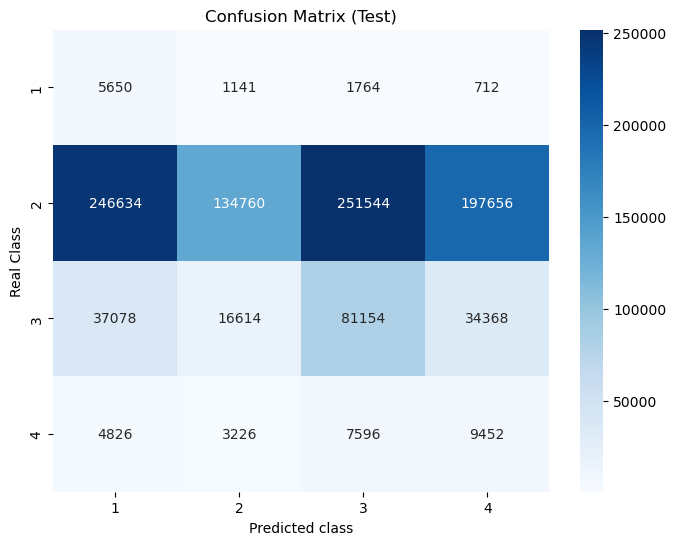

C:\Users\winona\anaconda3\envs\dataMining\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


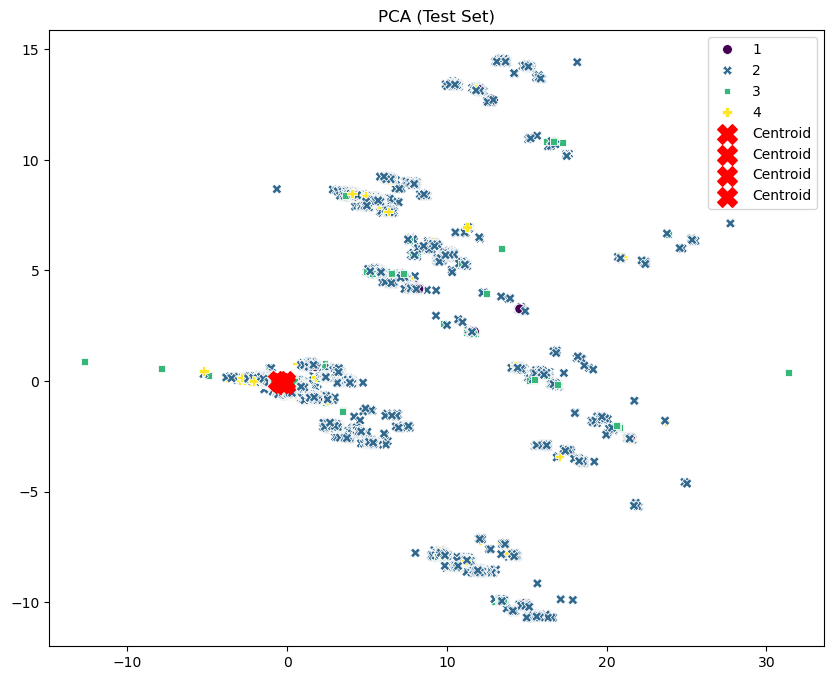

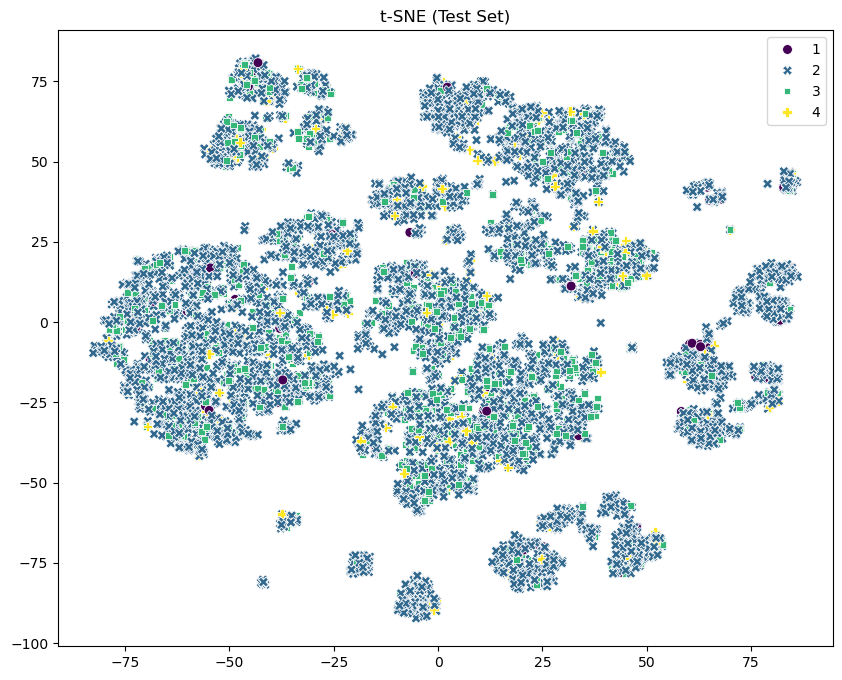

In [10]:
plot_confusion_matrix(y_test, y_test_pred, title="Confusion Matrix (Test)")
#plot_confusion_matrix(y_val, y_val_pred, title="Confusion Matrix (Validation)")
plot_pca(X_test, y_test, centroids)
plot_tsne(X_test, y_test)

In [11]:
def compute_probabilities(X, centroids):
    probabilities = []
    for x in X:
        distances = {cls: np.linalg.norm(x - centroid) for cls, centroid in centroids.items()}
        total_distance = sum(1 / (dist + 1e-6) for dist in distances.values())  # Adding a small constant to avoid zero division
        prob = {cls: (1 / (dist + 1e-6)) / total_distance for cls, dist in distances.items()}
        probabilities.append(prob)
    return probabilities

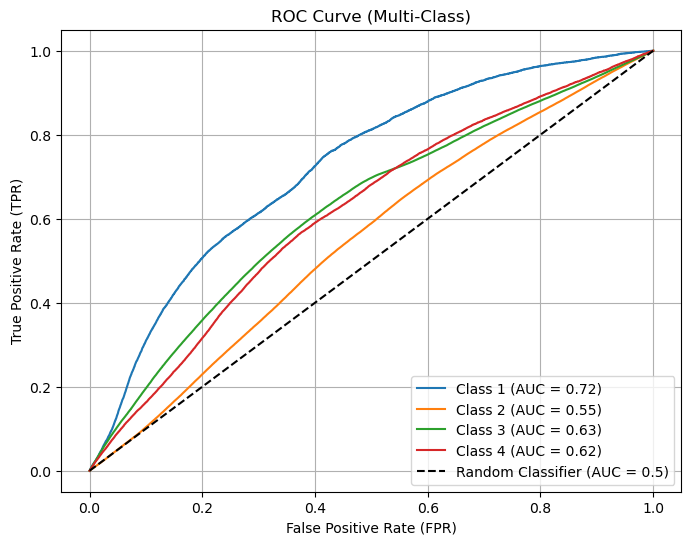

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Compute probabilities for each class
probabilities = compute_probabilities(X_test, centroids)

# Organize probabilities by class
prob_matrix = np.array([[prob[cls] for cls in classes] for prob in probabilities])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], prob_matrix[:, i])
    auc = roc_auc_score(y_test_bin[:, i], prob_matrix[:, i])
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve (Multi-Class)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [13]:
"""
if 'cluster' in data.columns:
    numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
    correlations = data[numeric_features].groupby('cluster').mean().corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation between Features and Clusters")
    plt.show()
"""

'\nif \'cluster\' in data.columns:\n    numeric_features = data.select_dtypes(include=[\'float64\', \'int64\']).columns\n    correlations = data[numeric_features].groupby(\'cluster\').mean().corr()\n\n    plt.figure(figsize=(12, 8))\n    sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")\n    plt.title("Correlation between Features and Clusters")\n    plt.show()\n'